# Lab Assignment 8
## Andrew Marquardt

In [6]:
# Libraries n' stuff
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
from tclab import TCLab, clock, Historian, Plotter

In [7]:
# Copied constants
CpH = 8.570225192333513 #Joules/degree C
CpS = 1.1198465579234749 #Joules/degree C
Ua = 0.03916910667788763 #Watts/degree C
Ub = 0.08256218948251515 #Watts/degree C
Uc = 0.03558351485126857 #Watts/degree C
alpha = 0.00016
P1 = 200
P2 = 100
Tamb = 21

In [8]:
# build operators and vectors
A = np.array([[-(Ua + Ub + Uc)/CpH, Ub/CpH, Uc/CpH, 0], 
              [Ub/CpS, -Ub/CpS, 0, 0],
              [Uc/CpH, 0, -(Ua + Ub + Uc)/CpH, Ub/CpH],
              [0, 0, Ub/CpS, -Ub/CpS]])

Bu = np.array([[alpha*P1/CpH, 0], [0, 0], [0, alpha*P2/CpH], [0, 0]])

Bd = np.array([[Ua/CpH], [0], [Ua/CpH], [0]])

C = np.array([[0, 1, 0, 0], [0, 0, 0, 1]])

# initial values for states and inputs
u_initial = np.array([0, 0])
d_initial = np.array([Tamb])
x_initial = np.array([Tamb, Tamb, Tamb, Tamb])

Setpoint Curves: Note the instructions were a little vague on how SP2 should be constructed, so I followed everything written and assumed this method is the correct one

In [16]:
# time grid
tf = 800
dt = 2
n = round(tf/dt)
t_grid = np.linspace(0, tf, n+1)

# setpoint/reference
def r1(t):
    return np.interp(t, [0, 50, 150, 450, 550], [Tamb, Tamb, 60, 60, 35])

def r2(t):
    return np.interp(t, [0,100,200,500,560], [Tamb,Tamb,60,60,45])

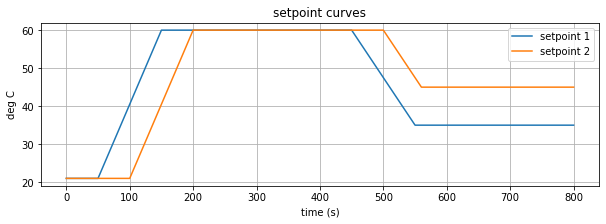

In [17]:
# plot functions
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(t_grid, r1(t_grid), label="setpoint 1")
ax.plot(t_grid, r2(t_grid), label="setpoint 2")
ax.set_title('setpoint curves')
ax.set_ylabel('deg C')
ax.set_xlabel('time (s)')
ax.legend()
ax.grid(True)

Least Squares Optimization

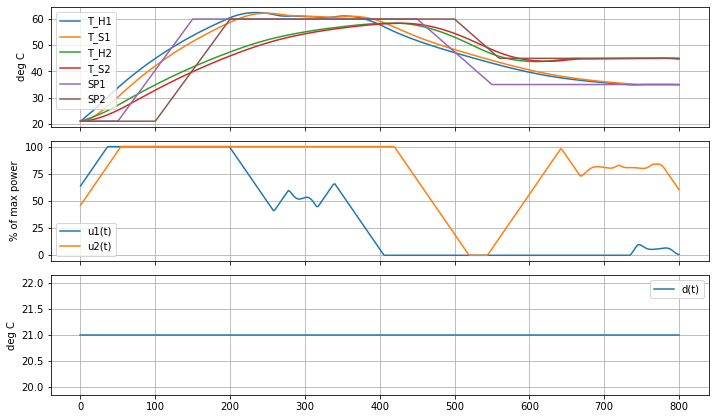

In [27]:
# disturbance function
def d(t):
    return np.interp(t,[0,400],[Tamb,Tamb])
    #return np.interp(t, [0, 300, 400], [Tamb, Tamb, Tamb-5])

# add $u$ as a decision variable
u = {t: cp.Variable(2, nonneg=True) for t in t_grid}
x = {t: cp.Variable(4) for t in t_grid}
y = {t: cp.Variable(2) for t in t_grid}

# least-squares optimization objective
objective1 = cp.Minimize(sum((y[t][0]-r1(t))**2 for t in t_grid))
objective2 = cp.Minimize(sum((y[t][1]-r2(t))**2 for t in t_grid))

model = [x[t] == x[t-dt] + dt*(A@x[t-dt] + Bu@u[t-dt] + Bd@[d(t-dt)]) for t in t_grid[1:]]
output = [y[t] == C@x[t] for t in t_grid]
inputs = [u[t] <= 100 for t in t_grid]
IC = [x[0] == np.array([Tamb,Tamb,Tamb,Tamb])]
rate = [cp.abs(u[t] - u[t-dt]) <= dt*1 for t in t_grid[1:]]

problem = cp.Problem(objective1 + objective2,  model + IC + output + inputs + rate)
problem.solve()

# display solution
fix, ax = plt.subplots(3, 1, figsize=(10,6), sharex=True)
ax[0].plot(t_grid, [x[t][0].value  for t in t_grid], label="T_H1")
ax[0].plot(t_grid, [x[t][1].value  for t in t_grid], label="T_S1")
ax[0].plot(t_grid, [x[t][2].value  for t in t_grid], label="T_H2")
ax[0].plot(t_grid, [x[t][3].value  for t in t_grid], label="T_S2")
ax[0].plot(t_grid, [r1(t) for t in t_grid], label="SP1")
ax[0].plot(t_grid, [r2(t) for t in t_grid], label="SP2")
ax[0].set_ylabel("deg C")
ax[0].legend()
ax[1].plot(t_grid, [u[t][0].value for t in t_grid], label="u1(t)")
ax[1].plot(t_grid, [u[t][1].value for t in t_grid], label="u2(t)")
ax[1].set_ylabel("% of max power")
ax[2].plot(t_grid, [d(t) for t in t_grid], label="d(t)")
ax[2].set_ylabel("deg C")
for a in ax:
    a.grid(True)
    a.legend()
plt.tight_layout()

In [38]:
# Final U1 and U2 functions
def U1(t):
    if t % 2 == 0 or t == 0:
        u1 = u[t][0].value
    elif t % 2 != 0:
        u1 = np.interp(t,[t-1,t+1],[u[t-1][0].value,u[t+1][0].value])
    return u1
def U2(t):
    if t % 2 == 0 or t == 0:
        u2 = u[t][1].value
    elif t % 2 != 0:
        u2 = np.interp(t,[t-1,t+1],[u[t-1][1].value,u[t+1][1].value])
    return u2    

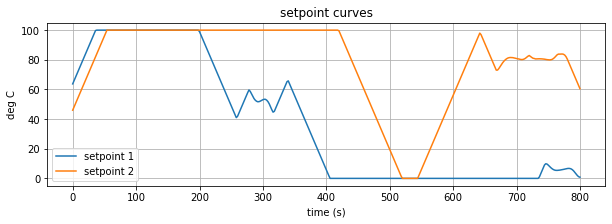

In [40]:
# Plot U1 and U2 without the clutter above
# plot functions
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(t_grid, [U1(t) for t in t_grid], label="setpoint 1")
ax.plot(t_grid, [U2(t) for t in t_grid], label="setpoint 2")
ax.set_title('setpoint curves')
ax.set_ylabel('deg C')
ax.set_xlabel('time (s)')
ax.legend()
ax.grid(True)

Test on TCLab

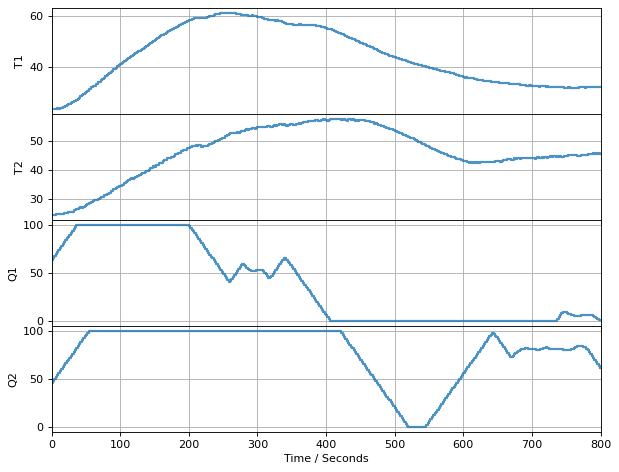

TCLab disconnected successfully.


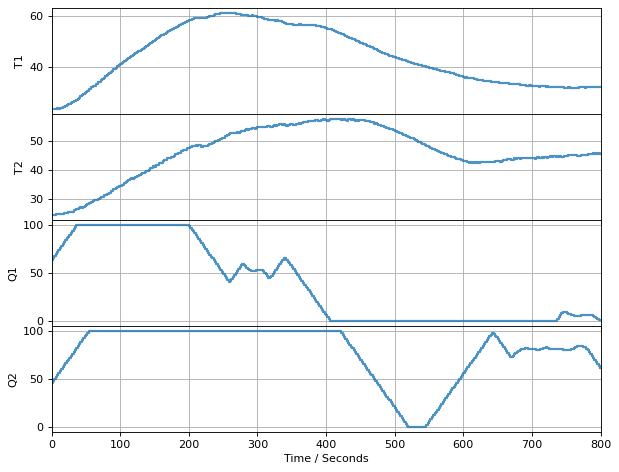

In [43]:
with TCLab() as lab:
    lab.P1 = P1
    lab.P2 = P2
    h = Historian(lab.sources)
    p = Plotter(h,tf)
    for t in clock(tf):
        lab.U1 = U1(round(t))
        lab.U2 = U2(round(t))
        p.update(t)

The model was far "cleaner" than the actual behavior.  It seems as if the model optimization solution worked for a scenario where the heater did not struggle to reach the highest temperatures.  Essentially, the model tended to underpredict the amount of time the heaters would spend at the high temperature soak but do a fairly decent job arriving at the second temperature soak.  This is interesting considering I would expect the model to underpredict consistently and have a difficult time reaching the final soak points, considering the issues reaching the high soak points.  Overall, however, the actual behavior shape did roughly represent the model goal behavior, so the model is not broken.